# PMF for Recommender Systems

This is an implementation for Probabilistic Matrix Factorisation. We have made use of a subset of the IMDB dataset for training purposes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import orthogonal_procrustes

from sklearn.metrics import mean_squared_error

In [2]:
mu = 0.0 
sigma_u = 1.0
sigma_v = 1.0
sigma = 0.2 #[0, 0.2, 0.4, 0.6, 0.8, 1] 
parameters = {}

d_dims = 2 
n_users = 10 
n_movies = 100 
alpha = 1
alpha_vals = [1, 3, 10, 30, 100] 
M_vals = [n_movies*alpha for alpha in alpha_vals]
k_best = 10 
nb_iter = 1000 

We will now initialise our parameters. First the $V$ matrix can be initialised randomly using the following distribution:

\begin{equation}
\large
V \sim \mathcal N\left(0, \frac {1} {\lambda_V}\right)
\end{equation}

Let's remember that:

\begin{equation}
\large
U \in \mathbb R^{D\times N}, \qquad V \in \mathbb R^{D\times M}
\end{equation}

Where $N$ is __n_users__, $M$ is __n_movies__ and $D$ is __n_dims__.

In [3]:
def condition(x):
    if x<=-2:
        return 0
    elif x>-2 and x<-1:
        return 1
    elif x>=-2 and x<=-0.5:
        return 2
    elif x>-0.5 and x<=0.5:
        return 3
    elif x>0.5 and x<=2:
        return 4
    else:
        return 5

In [4]:
def initialize_parameters(lambda_U, lambda_V, mu, sigma, alpha ):    
    U, V, R = generate_U_V_R(mu, lambda_U, lambda_V, sigma, alpha)    
    U_init = np.zeros((d_dims, n_users), dtype=np.float64)
    #U_init = np.random.normal(mu, 1.0 / lambda_U, (d_dims, n_users))
    V_init = np.random.normal(mu, 1.0 / lambda_V, (d_dims, n_movies*alpha))
    #scale R values within range 0-5
    applyall = np.vectorize(condition)
    R_res = applyall(R)
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['R'] = R_res
    parameters['U_result'] = U_init
    parameters['V_result'] = V_init
    parameters['lambda_U'] = lambda_U
    parameters['lambda_V'] = lambda_V

In [5]:
#generate matrices U, V and R from Gauss. distributions
def generate_U_V_R(mu, lambda_U, lambda_V, sigma, alpha):
    U = np.random.normal(mu, 1.0 / lambda_U, size=(d_dims,n_users))
    V = np.random.normal(mu, 1.0 / lambda_V, size=(d_dims,n_movies*alpha))
    noise = np.random.normal(mu, sigma, size=(n_users,n_movies*alpha)) 
    R = np.matmul(U.T,V) +noise
    return U, V, R

Let's now implement the function that updates U and V. The elements of both matrices can be updated using the following expressions:

\begin{equation}
\large
U_i=\left[\left(V_jV_j^T\right)_{j\in\Omega_{U_i}}+\lambda_UI\right]^{-1}\left(R_{ij}V_j^T\right)_{j\in\Omega_{U_i}}
\end{equation}

\begin{equation}
\large
V_j=\left[\left(U_iU_i^T\right)_{i\in\Omega_{V_j}}+\lambda_VI\right]^{-1}\left(R_{ij}U_i^T\right)_{i\in\Omega_{V_j}}
\end{equation}

In [6]:
def update_parameters():
    U = parameters['U_result']
    V = parameters['V_result']
    R = parameters['R']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']

    for i in range(n_users):
        V_j = V[:, R[i, :] > 0]
        U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(d_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        
    for j in range(n_movies):
        U_i = U[:, R[:, j] > 0]
        V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(d_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
 
    parameters['U_result'] = U
    parameters['V_result'] = V
    

In [7]:
#add code for evaluationg U, U_result and V, V_result

In [8]:
#frobenius norm 
def frob(X, Y, N):
    return np.linalg.norm(X - Y, 'fro')/np.sqrt(N)

In [9]:
def orth_procrustes(X, Y):
    R, scale = orthogonal_procrustes(X, Y)
    rss = np.linalg.norm(X @ R - Y, 'fro')
    return rss

In [10]:
def compare_results():
    U = parameters['U']
    V = parameters['V']
    U_result = parameters['U_result']
    V_result = parameters['V_result']    
    diff_norm_U = orth_procrustes(U, U_result)    #frob(U, U_result, n_users)
    diff_norm_V = orth_procrustes(V, V_result)   #frob(V, V_result, n_movies*alpha)#M_cols
    return diff_norm_U, diff_norm_V


Now let's implement the Log-a posteriori:

\begin{equation}
\large
L=-\frac 1 2 \left(\sum_{i=1}^N\sum_{j=1}^M(R_{ij}-U_i^TV_j)_{(i,j) \in \Omega_{R_{ij}}}^2+\lambda_U\sum_{i=1}^N\|U_i\|_{Fro}^2+\lambda_V\sum_{j=1}^M\|V_j\|_{Fro}^2\right)
\end{equation}

In [11]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    R = parameters['R']
    UV = np.dot(U_result.T, V_result)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U_result, U_result.T)) + \
                   lambda_V * np.sum(np.dot(V_result, V_result.T)))


The __predict__ function allows us to predict the rating value given the __user_id__ and the __movie_id__ parameters. The value has been scaled within the range 0-5

In [12]:
def predict(user_id, movie_id):
    U = parameters['U_result']
    V = parameters['V_result']
    
    r_ij = U[:, user_to_row[user_id]].T.reshape(1, -1) @ V[:, movie_to_column[movie_id]].reshape(-1, 1)

    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

The __evaluate__ function will calculate the __RMSE__ of the model given a dataset (train or test).

In [13]:
#def evaluate(dataset):
#    ground_truths = []
#    predictions = []
#    for index, row in dataset.iterrows():
#       ground_truths.append(row.loc['rating'])
#       predictions.append(predict(row.loc['userId'], row.loc['movieId']))    
#   return mean_squared_error(ground_truths, predictions, squared=False)

For the purposes of scaling, we need the maximum and minimum rating values.

In [14]:
def update_max_min_ratings():
    U = parameters['U_result']
    V = parameters['V_result']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

The __train__ function implements the code necessary for training the model as well as recording the __RMSE__ values on the training and testing sets.

In [15]:
def train(n_epochs):
    initialize_parameters(1.0 / sigma_u, 1.0 / sigma_v, mu, sigma, alpha)
    log_aps = []
    rmse_train = []
    rmse_test = []

    update_max_min_ratings()
    #rmse_train.append(evaluate(train_set))
    #rmse_test.append(evaluate(test_set))
    
    for k in range(n_epochs):
        update_parameters()
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)

        if (k + 1) % 10 == 0:
            update_max_min_ratings()

            #rmse_train.append(evaluate(train_set))
            #rmse_test.append(evaluate(test_set))
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()
    diff_norm_U, diff_norm_V = compare_results()
    return log_aps, rmse_train, rmse_test, diff_norm_U, diff_norm_V

Let's train our model!

In [18]:
log_ps, rmse_train, rmse_test, diff_norm_U, diff_norm_V = train(150)

Log p a-posteriori at iteration 10 : -409.42581643041507
Log p a-posteriori at iteration 20 : -376.30442569688927
Log p a-posteriori at iteration 30 : -364.44954473260833
Log p a-posteriori at iteration 40 : -359.75998530649275
Log p a-posteriori at iteration 50 : -357.80166312586346
Log p a-posteriori at iteration 60 : -356.9408193743251
Log p a-posteriori at iteration 70 : -356.54037534172903
Log p a-posteriori at iteration 80 : -356.3426502097962
Log p a-posteriori at iteration 90 : -356.23930945615865
Log p a-posteriori at iteration 100 : -356.1826016561688
Log p a-posteriori at iteration 110 : -356.1502773472174
Log p a-posteriori at iteration 120 : -356.13133725373547
Log p a-posteriori at iteration 130 : -356.12002769027606
Log p a-posteriori at iteration 140 : -356.1131895936881
Log p a-posteriori at iteration 150 : -356.1090216544133


In [19]:
print('Orthogonal Procrustes RSS for U :', diff_norm_U, '  for V:', diff_norm_V)

Orthogonal Procrustes RSS for U : 5.258797345825713   for V: 4.381297142366745


In [20]:
#print(parameters['R'])

Now let's take a look at some graphs

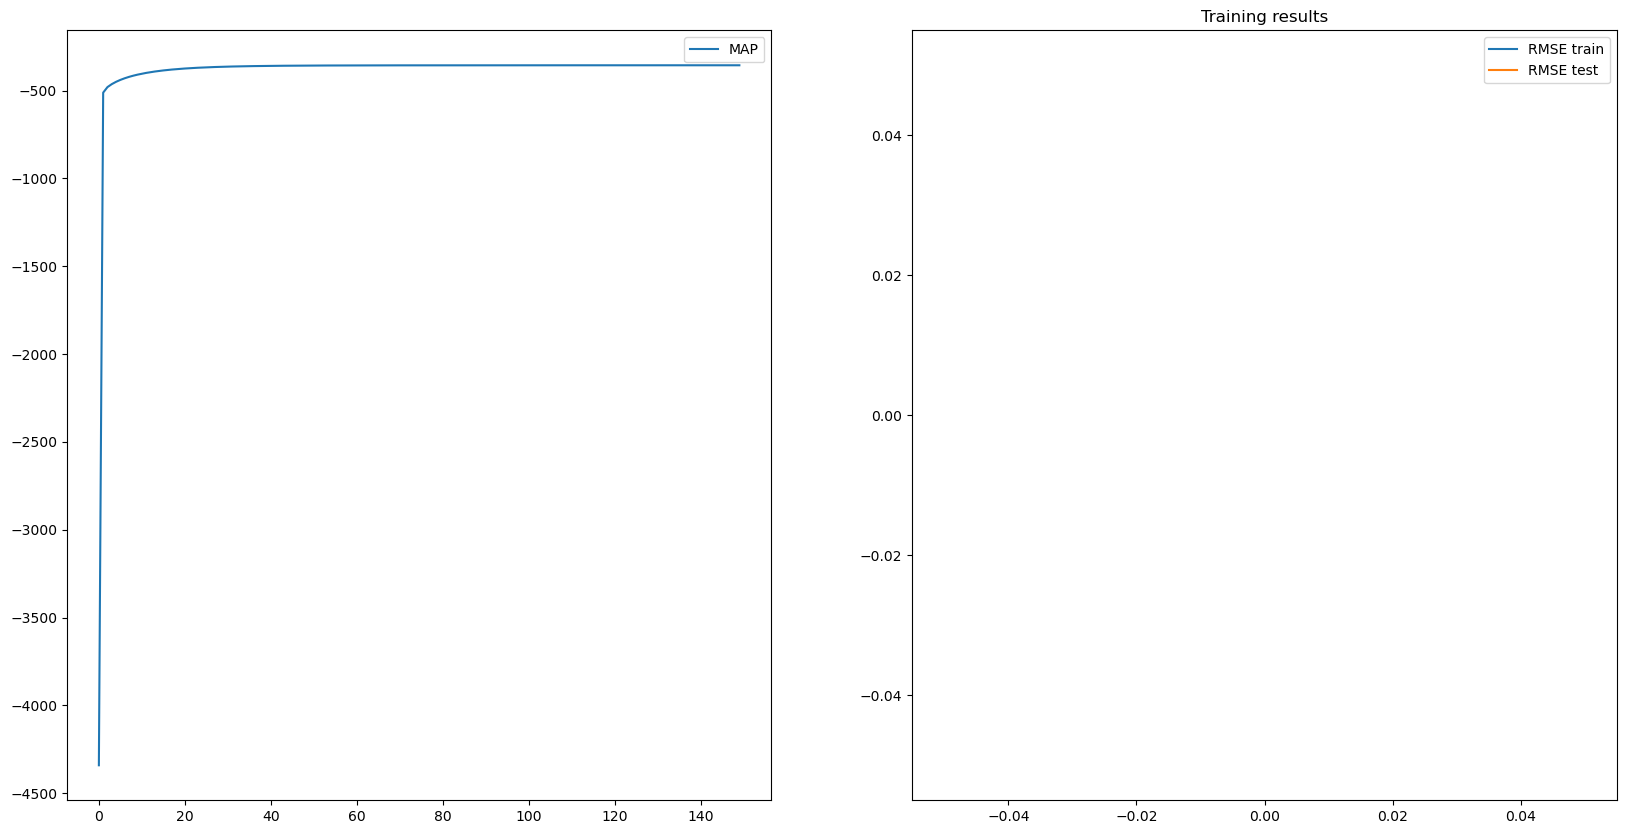

In [21]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()

plt.show()

Let's now evaluate our model on both the training and testing sets.

In [ ]:
print('RMSE of training set:', evaluate(train_set))
print('RMSE of testing set:', evaluate(test_set))

Now we will pick a user from the database and look at his/her preferences.

In [ ]:
user_id = 45
df_join[df_join['userId'] == user_id].sort_values(by=['rating'], ascending=False).head(10)

Let's look at the least preferred items.

In [ ]:
df_join[df_join['userId'] == user_id].sort_values(by=['rating']).head(10)

Let's now look at the most likely preferences of the selected user.

In [ ]:
predictions = np.zeros((n_movies, 1))
movie_to_column_items = np.array(list(movie_to_column.items()))
df_result = pd.DataFrame(columns=['UserID', 'MovieID', 'Movie', 'Genres', 'Prediction'])

for i, movie in enumerate(movie_to_column_items):
    predictions[i] = predict(user_id, movie[0])
    
indices = np.argsort(-predictions, axis=0)

for j in range(10):
    movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
    df_row = pd.DataFrame({
        'UserID': user_id,
        'MovieID': movie_id,
        'Movie': df_movies[df_movies['movieId'] == movie_id].iloc[0]['title'],
        'Genres': df_movies[df_movies['movieId'] == movie_id].iloc[0]['genres'],
        'Prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

Now the predictions for least preferred items.

In [ ]:
df_result = pd.DataFrame(columns=['UserID', 'MovieID', 'Movie', 'Genres', 'Prediction'])
indices = np.argsort(predictions, axis=0)

for j in range(10):
    movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
    df_row = pd.DataFrame({
        'UserID': user_id,
        'MovieID': movie_id,
        'Movie': df_movies[df_movies['movieId'] == movie_id].iloc[0]['title'],
        'Genres': df_movies[df_movies['movieId'] == movie_id].iloc[0]['genres'],
        'Prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

I hope you enjoyed this exercise. Something you can also try on your own is to implement gradient descent instead of MAP-estimation like I did here. Let me know about any comments you may have.